In [1]:
import numpy as np
import wurtzite as wzt
import matplotlib.pyplot as plt
import matplotlib

### Method and discussion:

Zakladamy tutaj nastepujace rownania Love'a:

$u_x = \frac{b_x}{2\pi}[arctg(\frac{y}{x}) + \frac{xy}{2(1-\nu)(x^2 + y^2)}]$

$u_y = -\frac{b_x}{2\pi}[\frac{1-2\nu}{4(1-\nu)}ln\frac{x^2+y^2}{r_o^2} + \frac{x^2-y^2}{4(1-\nu)(x^2+y^2)}]$

$u_z = \frac{bz}{2\pi}arctg(\frac{y}{x})$

Rozumiem, że istnieją **założenia** co do tego, kiedy dane równanie może być zaaplikowane, np. że każda płaszczyzna krystalograficzna jest "płaska".

Założenia te nie są spełnione po zaaplikowaniu pierwszej dyslokacji. Możemy więc spróbować przekształcić siatkę po pierwszej dyslokacji do nowej "przestrzeni", w której te założenia będą już spełnione.

Dla uproszczenia dalszej analizy przyjmijmy przez chwilę, że warunek "płaszczyzna krystalograficzna jest "płaska"" oznacza, że wszystkie punkty na tej samej płaszczyźnie krystalograficznej mają taką samą współrzędną $y$.

Możemy więc przyjąć następującą strategię ($\mathbf{x} = (x, y, z)$, $\mathbf{u} = (u_x, u_y, u_z)$):

1. Przekształcamy $\mathbf{x}$ do nowej przestrzeni: $\mathbf{x} \rightarrow \mathbf{x}'$, w której wszystkie punkty z jednej płaszczyzny mają takie same $y$.
2. W przestrzeni rozwiązujemy równanie $\mathbf{u}' = f(\mathbf{x}'+\mathbf{u}')$ wzgl. $\mathbf{u}'$.
3. Przesuwamy o znalezione przesunięcie $\mathbf{x}' \leftarrow \mathbf{x}' + \mathbf{u}'$.
4. Przekształcamy w drugą stronę: $\mathbf{x}' \rightarrow \mathbf{x}$.

W jednej z prostszych sytuacji, jeżeli chcemy spełnić warunek że warunek "wszystkie punkty na tej samej płaszczyźnie krystalograficznej mają taką samą współrzędną $y$", to możemy sprobówać przyjąć następujące przekształcenie $\mathbf{x} \rightarrow \mathbf{x}'$.


$x' = x$

$y' = y - \Delta y(x, y, z)$

$z' = z$

oraz przeksztalcenie odwrotne:


$x = x'$

$y = y' + \Delta y(x, y, z)$

$z = z'$


Gdzie $\Delta y(x, y, z) = y_c - y_0$, gdzie $y_c$ to położenie $y$ atomów z konfiguracji aktualnej, $y_0$ to położenie atomów z konfiguracji pierwotnej (np. wyznaczone dla pierwszej z dyslokacji).


W punkcie 2. podstawiamy nowe $\mathbf{x}'$ do wzorów Love'a:

$u_x' = \frac{b_x}{2\pi}[arctg(\frac{y'}{x'}) + \frac{x'y'}{2(1-\nu)(x'^2 + y'^2)}]$

$u_y' = -\frac{b_x}{2\pi}[\frac{1-2\nu}{4(1-\nu)}ln\frac{x'^2+y'^2}{r_o^2} + \frac{x'^2-y'^2}{4(1-\nu)(x'^2+y'^2)}]$

$u_z' = \frac{bz}{2\pi}arctg(\frac{y'}{x'})$


(**UWAGA**: $y' = y - \Delta y(x, y, z)$, i należy brać to brać pod uwagę w sytuacji, gdyby była potrzebna np. $\frac{\delta u_x'}{\delta y}$ (bety); my tu jednak zakładamy, że liczymy $\frac{\delta u_x'}{\delta y'}$)

Rozwiązujemy równanie $\mathbf{u}' = f(\mathbf{x}'+\mathbf{u}')$ (np. metodą Newtona-Raphsona), i przekształcamy spowrotem do naszej oryginalnej przestrzeni używając przyjętej $\mathbf{x}' \rightarrow \mathbf{x}$.



## Initial configuration

In [2]:
l0 = wzt.generate.create_lattice(
    dimensions=(10, 10, 2),  #  The number of cells
    cell="B4_ZnS",
)

Reading bond: 1213/1213

Text(0.5, 1.0, 'Initial configuration')

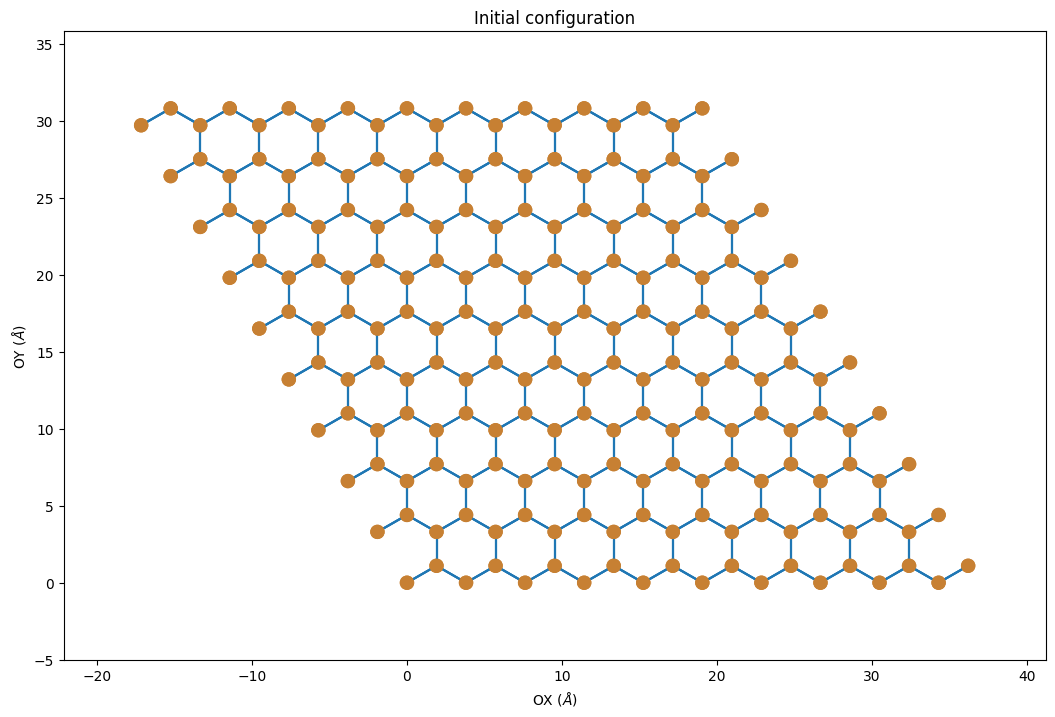

In [3]:
fig, ax = wzt.visualization.plot_atoms_2d(l0)
ax.set_title("Initial configuration")

## Dislocations

Genearting dislocation: DislocationDef(b=[1, 0, 0], position=[5, 6, 7.5], plane=(0, 0, 1), label='$d_1$: type: 8', color='deepskyblue')
Reading bond: 1213/1213

<Figure size 640x480 with 0 Axes>

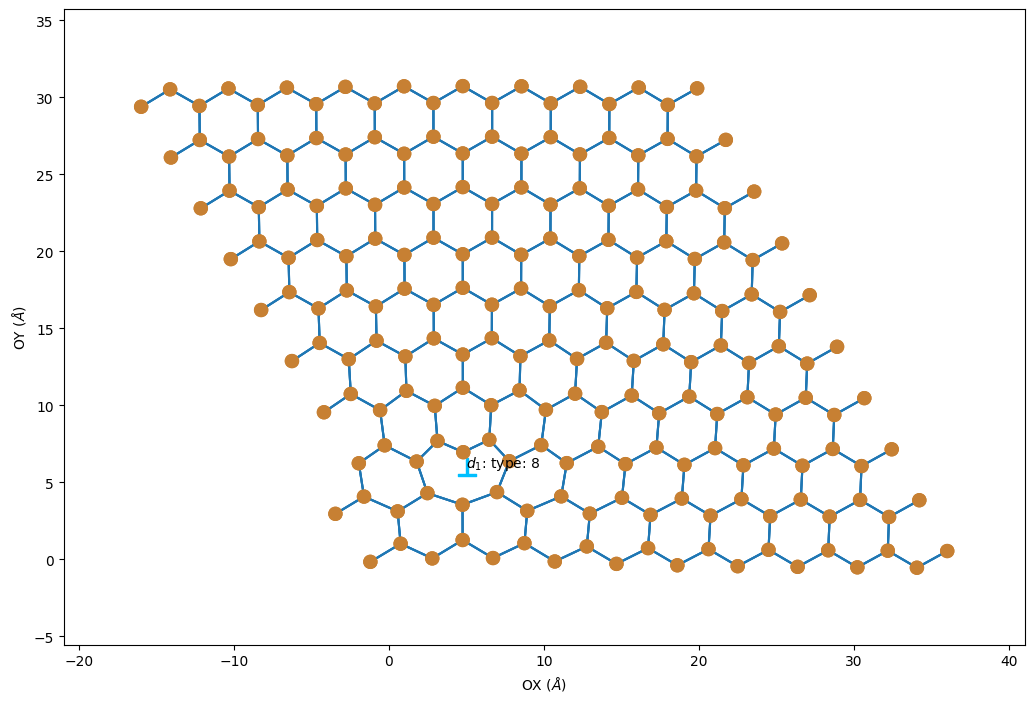

In [4]:
from dataclasses import dataclass

us = []


@dataclass(frozen=True)
class DislocationDef:
    b: np.ndarray
    position: np.ndarray
    plane: tuple
    label: str
    color: str = "brown"



def add_dislocation(crystal, l0, d):
    print(f"Genearting dislocation: {d}")
    delta_y = np.zeros(l0.coordinates.shape)
    delta_y[:, 1] = crystal.coordinates[:, 1] - l0.coordinates[:, 1]
    delta_y = np.squeeze(delta_y)
    # transform into...
    l_t = crystal.translate(-delta_y)
    
    u = wzt.dislocations.displace_love(
        crystal=l_t,
        position=d.position,
        burgers_vector=d.b,
        plane=d.plane,
        bv_fraction=1.0,
        tolerance=1e-4
    )
    l_t = l_t.translate(u)
    # transform back
    l = l_t.translate(delta_y)
    l = wzt.generate.update_bonds(l)
    return l


def display_crystal_with_dislocations(crystal, dis):
    plt.figure()
    fig, ax = wzt.visualization.plot_atoms_2d(crystal)
    plt.scatter(dis.position[0], dis.position[1], s=200.5, c=dis.color, marker="$\\bot$")
    plt.text(dis.position[0], dis.position[1], dis.label, zorder=1000)


d1 = DislocationDef(
    b=[1, 0, 0],
    position=[5, 6, 7.5],
    plane=(0, 0, 1),
    label="$d_1$: type: 8",
    color="deepskyblue"
)

l1 = add_dislocation(l0, l0, d1)
display_crystal_with_dislocations(l1, d1)

Genearting dislocation: DislocationDef(b=[1, 0, 0], position=[-8.82, 25.91, 7.5], plane=(0, 0, 1), label='$d_2$: type: 8', color='brown')
Reading bond: 1213/1213

<Figure size 640x480 with 0 Axes>

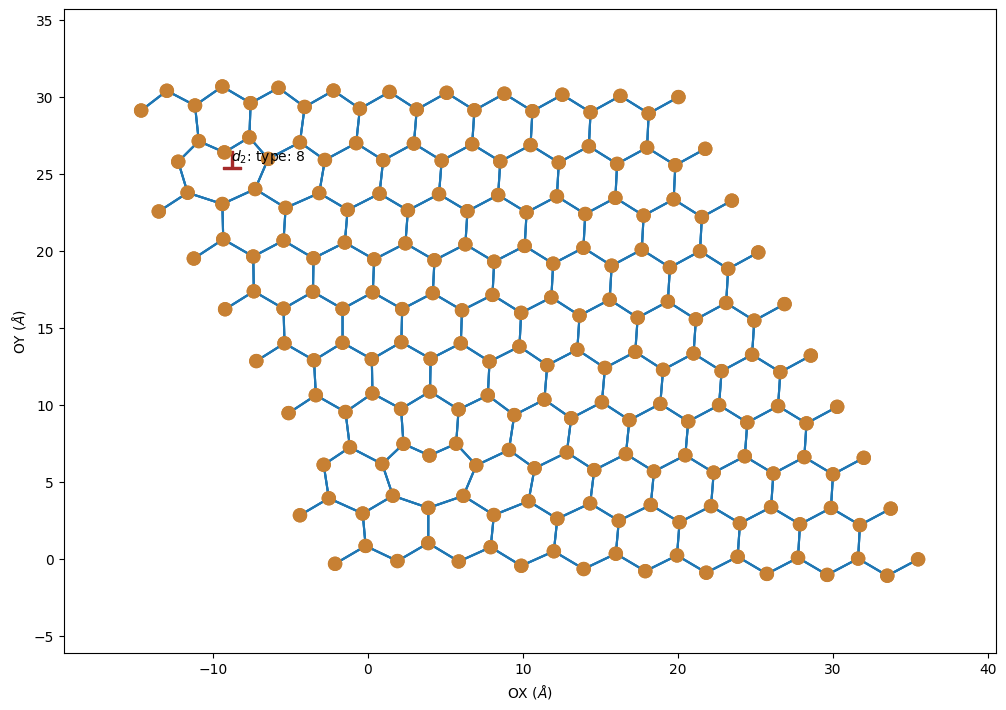

In [5]:
d2 = DislocationDef(
    b=[1, 0, 0],
    position=[-8.82, 25.91, 7.5],
    plane=(0, 0, 1),
    label="$d_2$: type: 8",
    color="brown" 
)

l2 = add_dislocation(l1, l0, d2)
display_crystal_with_dislocations(l2, d2)

Genearting dislocation: DislocationDef(b=[-1, 0, 0], position=[24.65, 6.16, 7.5], plane=(0, 0, 1), label='$d_3$: type: 5:7', color='palegreen')
Reading bond: 1210/1210

<Figure size 640x480 with 0 Axes>

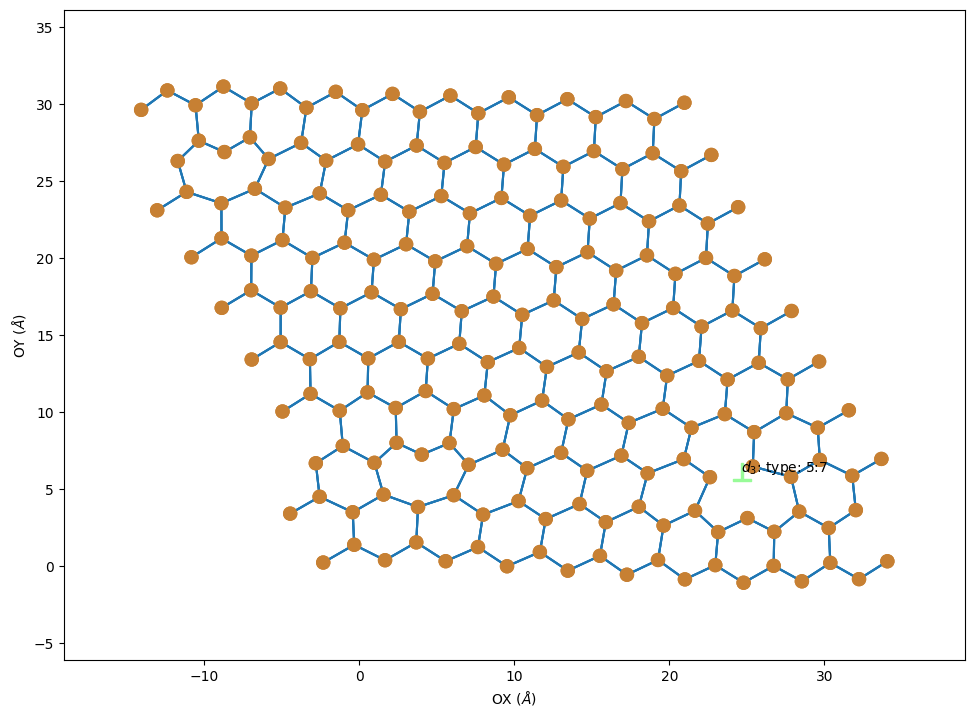

In [6]:
d3 = DislocationDef(
    b=[-1, 0, 0],
    position=[24.65, 6.16, 7.5],
    plane=(0, 0, 1),
    label="$d_3$: type: 5:7",
    color="palegreen"
)

l3 = add_dislocation(l2, l0, d3)
display_crystal_with_dislocations(l3, d3)

Genearting dislocation: DislocationDef(b=[-1, 0, 0], position=[15.15, 26.24, 7.5], plane=(0, 0, 1), label='$d_4$: type: 5:7', color='salmon')
Reading bond: 1207/1207The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


<Figure size 640x480 with 0 Axes>

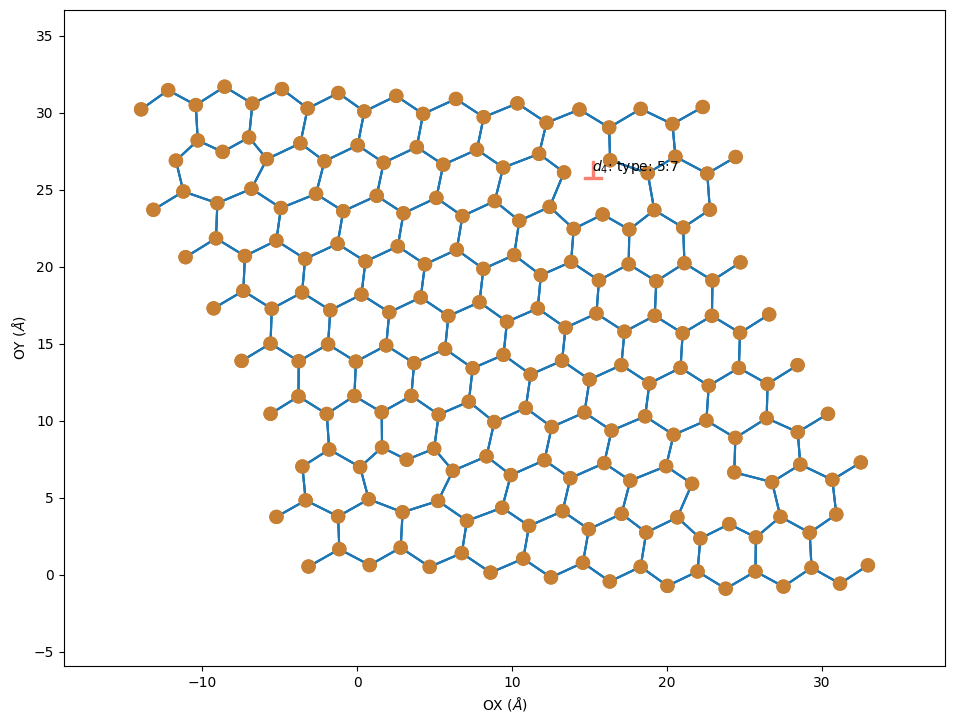

In [7]:
d4 = DislocationDef(
    b=[-1, 0, 0],
    position=[15.15, 26.24, 7.5],
    plane=(0, 0, 1),
    label="$d_4$: type: 5:7",
    color="salmon"
)

l4 = add_dislocation(l3, l0, d4)
display_crystal_with_dislocations(l4, d4)